# Deploying and Using CxrReportGen model for Inference using Online Endpoints

This sample demonstrates how to deploy a CxrReportGen, a multimodal AI model that generates detailed, structured radiology reports from chest X-ray images, incorporating both current and prior images, along with key patient information, to an online endpoint. For this notebook, we use Python 3.10 - AzureML SDK v2.

### Task
The CXRReportGen task processes chest X-ray images, generating a list of findings along with overlays on the images highlighting the areas of the image to which the findings are related.

In this notebook we will perform programmatic deployment of the model from the Azure AI Studio/Azure Machine Learning Studio Model Catalog, then send some images to the model, inspect the results and visualize the bounding boxes. Note that you can also perform deployment through the Model Catalog UI and use this notebook to issue calls to that endpoint.
 
### Model
The model is multimodal, using the BiomedClip architecture as the image encoder and the Phi-3-mini-4k-instruct architecture as the text encoder.

### Inference data
We will use chest X-ray images and text. 

### Outline
1. Setup pre-requisites
2. Pick a model to deploy
3. Deploy the model to an online endpoint
4. Test the endpoint
5. Clean up resources - delete the endpoint

## 1. Setup pre-requisites
* Connect to AzureML Workspace and authenticate.
* Or, in AI Foundry, create an endpoint and deployment and reference below, in this way there is no need to deploy MAAP VM every time!

The code below uses config-based initialization of MLClient. On an Azure Machine Learning VM this code will read config.json that is automatically generated and located in the root of your VM. If you are running it elsewhere, you can create such config by placing it in your working directory with the following content:

```JSON
{
"subscription_id": "YOUR_SUBSCRIPTION_ID",
"resource_group": "YOUR_AZURE_RESOURCE_GROUP",
"workspace_name": "YOUR_AZURE_ML_WORKSPACE_NAME"
}
```


In [1]:
from azure.ai.ml import MLClient
from azure.identity import (
    DefaultAzureCredential,
    InteractiveBrowserCredential,
)
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
)

try:
    credential = DefaultAzureCredential()
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    credential = InteractiveBrowserCredential()

## 2. Pick a model to deploy

In this example, we use the `CxrReportGen` model. If you have opened this notebook for a different model, replace the model name accordingly.

### Download the config.json from AML workspace overview

In [2]:
# The models are available in the AzureML system registry, "azureml"
registry_ml_client = MLClient(
    credential,
    registry_name="azureml",
)
model = registry_ml_client.models.get(name="CxrReportGen", label="latest")
ml_client = MLClient.from_config(credential)

Found the config file in: /Users/wanmeng/repository/healthcareai-examples/config.json


In [2]:
ml_client = MLClient.from_config(credential)

Found the config file in: /Users/wanmeng/repository/healthcareai-examples/config.json


## 3. Deploy the model to an online endpoint for real time inference
Online endpoints give a durable REST API that can be used to integrate with applications that need to use the model.

The steps below show how to deploy an endpoint programmatically. You can skip the steps in this section if you just want to test an existing endpoint. 

In [3]:
import random
import string

endpoint_name = "CxrReportGen"

# Creating a unique endpoint name by including a random suffix
allowed_chars = string.ascii_lowercase + string.digits
endpoint_suffix = "".join(random.choice(allowed_chars) for x in range(5))
endpoint_name = f"{endpoint_name}-{endpoint_suffix}"

print(f"Endpoint name: {endpoint_name}")

Endpoint name: CxrReportGen-513e1


In [4]:
endpoint = ManagedOnlineEndpoint(name=endpoint_name)
endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()

In [5]:
from azure.ai.ml.entities import OnlineRequestSettings

deployment_name = "cxr-report-gen-v440"
deployment_package = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=endpoint_name,
    model=model,
    # Note: This is the minimum required VM for this model.  You may need to request quota for its use.  Please see model card for more details.
    instance_type="Standard_NC24ads_A100_v4",
    instance_count=1,
    request_settings=OnlineRequestSettings(request_timeout_ms=90000),
    app_insights_enabled=True,
)

In [6]:
_ = ml_client.online_deployments.begin_create_or_update(deployment_package).result()

Check: endpoint CxrReportGen-513e1 exists


........................................................................................................................................................................................................................................................................................................................................................................

## 4. Test the endpoint - base64 encoded image and text
We will use two chest X-ray images, one frontal and one lateral, from the data directory.

In [3]:
# Some support functions to help with the image processing, scoring and visualization

import json
import base64
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image


def read_image(image_path):
    """Reads an image from a file path and returns the image as a byte array."""
    with open(image_path, "rb") as f:
        return f.read()


def write_request_file(
    frontal_path,
    lateral_path,
    indication,
    technique,
    comparison,
    request_file_name="sample_request_data.json",
):
    """Scores frontal and lateral images using the deployed model."""

    input_data = {
        "frontal_image": base64.encodebytes(read_image(frontal_path)).decode("utf-8"),
        "lateral_image": base64.encodebytes(read_image(lateral_path)).decode("utf-8"),
        "indication": indication,
        "technique": technique,
        "comparison": comparison,
    }

    data = {
        "input_data": {
            "columns": list(input_data.keys()),
            "index": [0],
            "data": [
                list(input_data.values()),
            ],
        },
        "params": {},
    }

    # Create request json

    with open(request_file_name, "w") as request_file:
        json.dump(data, request_file)

    return request_file_name


def adjust_box_for_original_image_size(norm_box, width: int, height: int):
    """
    Assuming we did a centre crop to the shortest size, adjust the box coordinates back to the original shape of the image.
    :param norm_box: A normalized box to rescale.
    :param width: Original width of the image, in pixels.
    :param height: Original height of the image, in pixels.
    :return: The box normalized relative to the original size of the image.
    """
    crop_width = crop_height = min(width, height)
    x_offset = (width - crop_width) // 2
    y_offset = (height - crop_height) // 2
    norm_x_min, norm_y_min, norm_x_max, norm_y_max = norm_box
    abs_x_min = int(norm_x_min * crop_width + x_offset)
    abs_x_max = int(norm_x_max * crop_width + x_offset)
    abs_y_min = int(norm_y_min * crop_height + y_offset)
    abs_y_max = int(norm_y_max * crop_height + y_offset)
    adjusted_norm_x_min = abs_x_min / width
    adjusted_norm_x_max = abs_x_max / width
    adjusted_norm_y_min = abs_y_min / height
    adjusted_norm_y_max = abs_y_max / height
    return (
        adjusted_norm_x_min,
        adjusted_norm_y_min,
        adjusted_norm_x_max,
        adjusted_norm_y_max,
    )


def show_image_with_bbox(path_frontal, findings, path_lateral=None):
    """Displays frontal and lateral images with bounding boxes around the findings."""
    image_frontal = Image.open(path_frontal)
    width_frontal, height_frontal = image_frontal.size

    if path_lateral:
        image_lateral = Image.open(path_lateral)
        _, axes = plt.subplots(1, 2, figsize=(20, 10))
        axes[0].imshow(image_frontal, cmap="gray")
        axes[1].imshow(image_lateral, cmap="gray")
    else:
        _, axes = plt.subplots(figsize=(10, 10))
        axes.imshow(image_frontal, cmap="gray")
        axes = [axes]

    findings_str = []
    for idx, (finding, boxes) in enumerate(findings):
        findings_str.append(f"{idx}. {finding}{' * ' if boxes else ' '}")
        if boxes:
            for box in boxes:
                box = adjust_box_for_original_image_size(
                    box, width_frontal, height_frontal
                )
                x_min, y_min, x_max, y_max = (
                    box[0] * width_frontal,
                    box[1] * height_frontal,
                    box[2] * width_frontal,
                    box[3] * height_frontal,
                )

                rect = plt.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    edgecolor="red",
                    facecolor="none",
                    linewidth=2,
                )
                axes[0].add_patch(rect)
                axes[0].text(
                    x_min + 3,
                    y_min + 3,
                    f"Finding ID: {idx}",
                    color="yellow",
                    fontsize=10,
                    verticalalignment="top",
                )

    for ax in axes:
        ax.axis("off")  # Hide the axes

    plt.show()
    print("\n".join(findings_str))

## Download data

Use the following command to download the dataset with samples into your data folder located at `/home/azureuser/data/healthcare-ai/cxrreportgen-images`:

`azcopy copy --recursive https://azuremlexampledata.blob.core.windows.net/data/healthcare-ai/cxrreportgen-images /home/azureuser/data/healthcare-ai/`

In [5]:
!azcopy copy --recursive "https://azuremlexampledata.blob.core.windows.net/data/healthcare-ai/cxrreportgen-images" /Users/wanmeng/repository/healthcareai-examples/data

INFO: Scanning...
^C


# If you skipped the programmatic deployment step, and just want to test the endpoint that you already have, you can uncomment the strings below and add your endpoint and deployment names.

### endpoint_name is not endpoint url

In [4]:
# If you skipped the programmatic deployment step, and just want to test the endpoint that you already have, you can uncomment the strings below and add your endpoint and deployment names.
#endpoint_name is not endpoint url
endpoint_name = "wanmeng-7491-yjpue"
deployment_name = "cxrreportgen-4"

In [5]:
# Now let's pass frontal and lateral images to the model and visualize the results

frontal = "/Users/wanmeng/repository/healthcareai-examples/images/healthcare-ai/cxrreportgen-images/cxr_frontal.jpg"
lateral = "/Users/wanmeng/repository/healthcareai-examples/images/healthcare-ai/cxrreportgen-images/cxr_lateral.jpg"

indication = ""
technique = ""
comparison = "None"


request_file_name = write_request_file(
    frontal, lateral, indication, technique, comparison
)

# Note uncomment and set to use an endpoint not deployed in this notebook
# endpoint_name = ""
# deployment_name = ""

response = ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)
# Parse the response into an array
findings = json.loads(json.loads(response)[0]["output"])

print(findings)

[['The heart size is normal.', None], ['The aorta is tortuous.', [[0.415, 0.225, 0.635, 0.755]]], ['A patchy infiltrate in the right lower lobe is associated with volume loss.', [[0.115, 0.445, 0.445, 0.795]]], ['A small right pleural effusion is present.', [[0.115, 0.555, 0.425, 0.845]]], ['The left hemithorax is grossly clear.', None]]


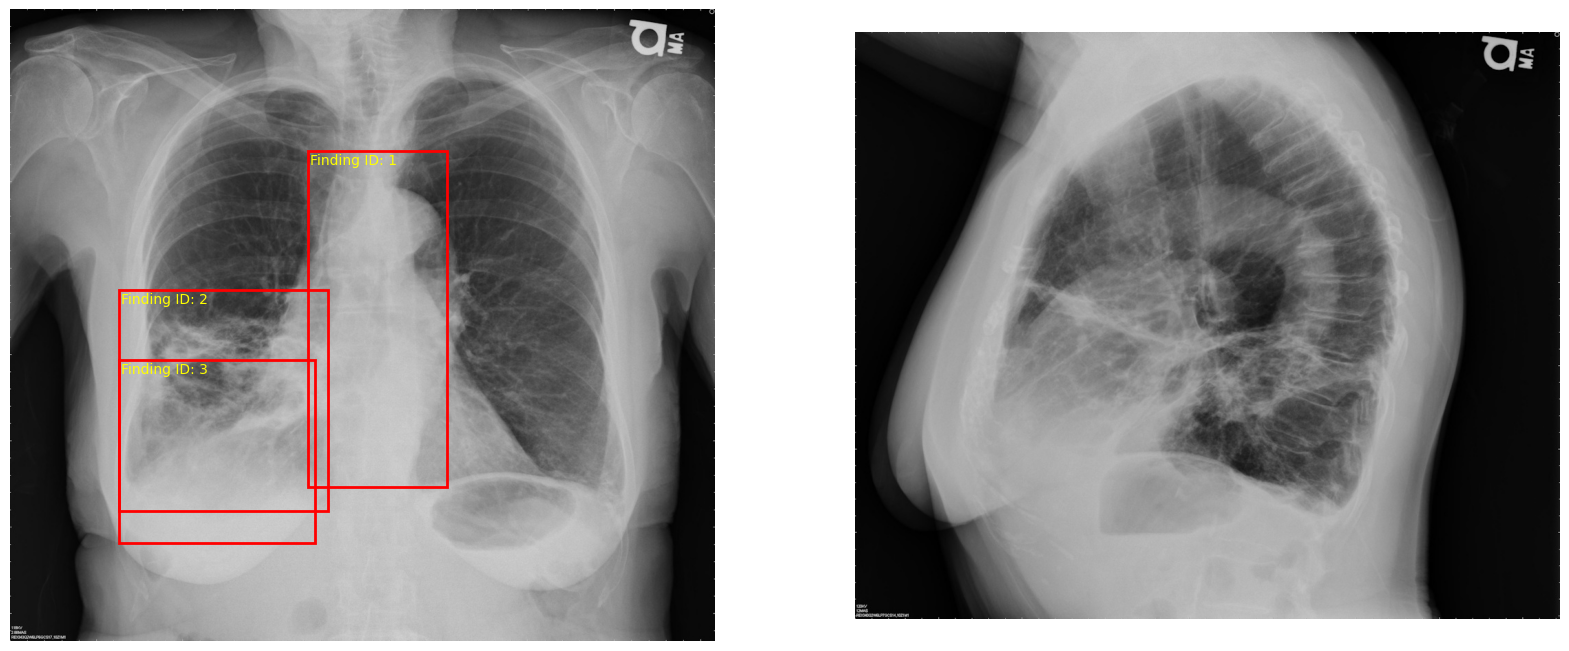

0. The heart size is normal. 
1. The aorta is tortuous. * 
2. A patchy infiltrate in the right lower lobe is associated with volume loss. * 
3. A small right pleural effusion is present. * 
4. The left hemithorax is grossly clear. 


In [6]:
show_image_with_bbox(frontal, findings, path_lateral=lateral)

In [19]:
# Now let's pass frontal and lateral images to the model and visualize the results

frontal = "/Users/wanmeng/repository/healthcareai-examples/images_client/CHEST PA＿I00220866332.png"

indication = "abnormal lung"
technique = "chest PA"
comparison = "None"



def write_single_request_file(
    frontal_path,
    indication,
    technique,
    comparison,
    request_file_name="single_request_data.json",
):
    """Scores frontal and lateral images using the deployed model."""

    input_data = {
        "frontal_image": base64.encodebytes(read_image(frontal_path)).decode("utf-8"),
        "indication": indication,
        "technique": technique,
        "comparison": comparison,
    }

    data = {
        "input_data": {
            "columns": list(input_data.keys()),
            "index": [0],
            "data": [
                list(input_data.values()),
            ],
        },
        "params": {},
    }

    # Create request json

    with open(request_file_name, "w") as request_file:
        json.dump(data, request_file)

    return request_file_name



request_file_name = write_single_request_file(
    frontal, None, indication, technique, comparison
)

# Note uncomment and set to use an endpoint not deployed in this notebook
# endpoint_name = ""
# deployment_name = ""

response = ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)
# Parse the response into an array
findings = json.loads(json.loads(response)[0]["output"])

print(findings)

[['Nasogastric tube overlies the stomach.', [[0.445, 0.005, 0.645, 0.995]]], ['The heart size is normal.', None], ['There is hazy opacification of the left mid and lower lung field.', [[0.505, 0.335, 0.835, 0.835]]], ['The left upper hemithorax is clear.', None], ['The right hemithorax demonstrates blunting of the right costophrenic angle.', [[0.115, 0.615, 0.335, 0.855]]]]


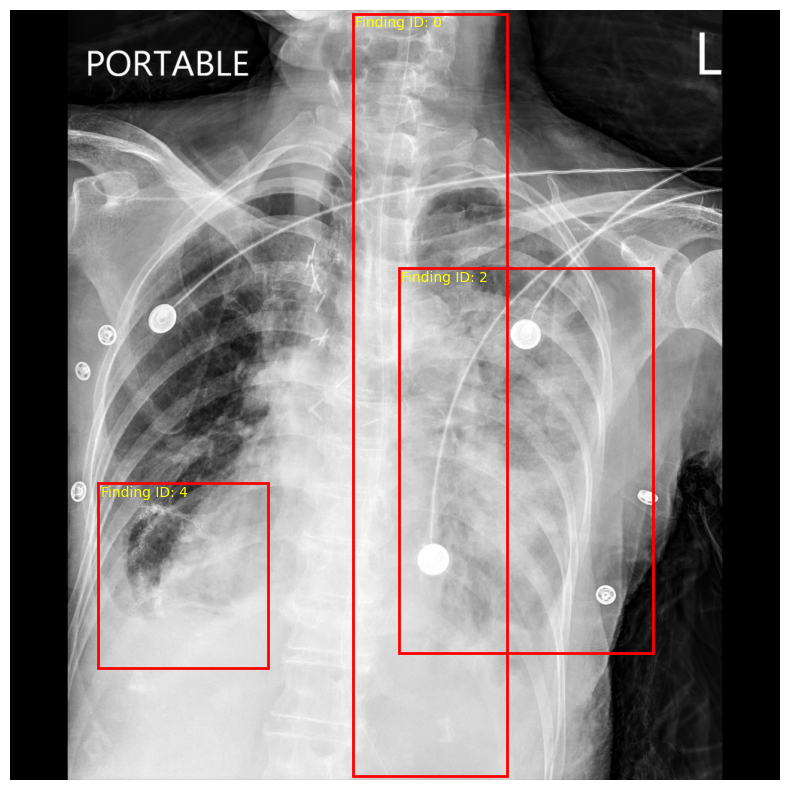

0. Nasogastric tube overlies the stomach. * 
1. The heart size is normal. 
2. There is hazy opacification of the left mid and lower lung field. * 
3. The left upper hemithorax is clear. 
4. The right hemithorax demonstrates blunting of the right costophrenic angle. * 


In [20]:
show_image_with_bbox(frontal, findings, path_lateral=None)

### [['鼻胃管覆盖在胃上。', [[0.445, 0.005, 0.645, 0.995]]], ['心脏大小正常。', None], ['左侧中下肺野有模糊的影像学浑浊。', [[0.505, 0.335, 0.835, 0.835]]], ['左侧上半胸腔清晰。', None], ['右侧胸腔显示右侧膈角模糊。', [[0.115, 0.615, 0.335, 0.855]]]]

In [21]:
# Now let's pass frontal and lateral images to the model and visualize the results

frontal = "/Users/wanmeng/repository/healthcareai-examples/images_client/CHEST PA＿I00220866332.png"

indication = "abnormal lung, locate the abnormal part"
technique = "chest PA"
comparison = "None"



def write_single_request_file(
    frontal_path,
    indication,
    technique,
    comparison,
    request_file_name="single_request_data.json",
):
    """Scores frontal and lateral images using the deployed model."""

    input_data = {
        "frontal_image": base64.encodebytes(read_image(frontal_path)).decode("utf-8"),
        "indication": indication,
        "technique": technique,
        "comparison": comparison,
    }

    data = {
        "input_data": {
            "columns": list(input_data.keys()),
            "index": [0],
            "data": [
                list(input_data.values()),
            ],
        },
        "params": {},
    }

    # Create request json

    with open(request_file_name, "w") as request_file:
        json.dump(data, request_file)

    return request_file_name



request_file_name = write_single_request_file(
    frontal, None, indication, technique, comparison
)

# Note uncomment and set to use an endpoint not deployed in this notebook
# endpoint_name = ""
# deployment_name = ""

response = ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)
# Parse the response into an array
findings = json.loads(json.loads(response)[0]["output"])

print(findings)

[['The heart size is normal.', None], ['There is hazy opacification at the left lung base.', [[0.505, 0.465, 0.835, 0.835]]], ['The left upper hemithorax is clear.', None], ['The right lung is clear.', None], ['Nasogastric tube overlies the stomach.', [[0.445, 0.005, 0.725, 0.985]]]]


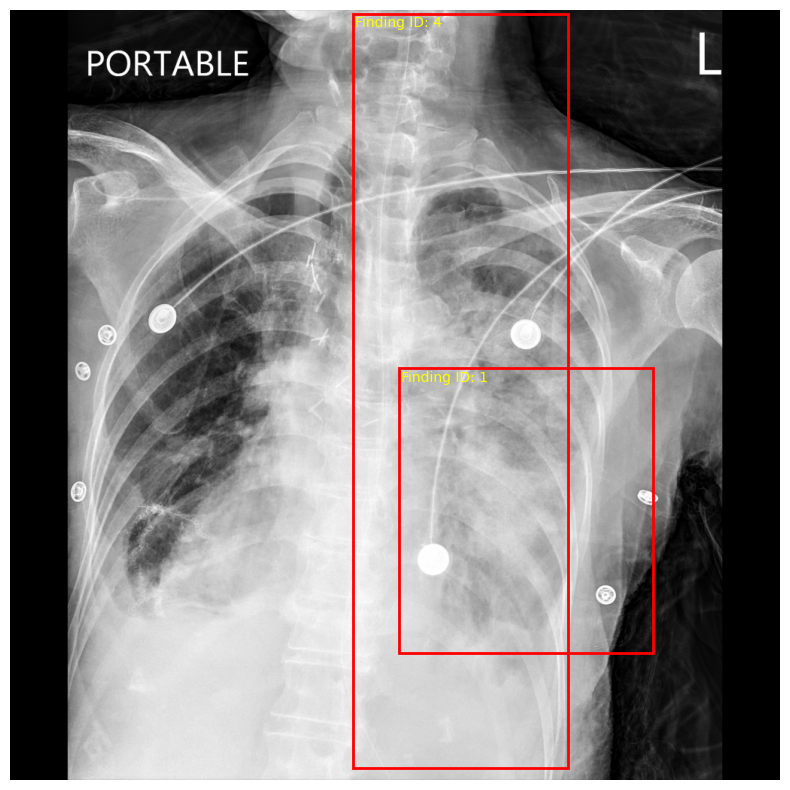

0. The heart size is normal. 
1. There is hazy opacification at the left lung base. * 
2. The left upper hemithorax is clear. 
3. The right lung is clear. 
4. Nasogastric tube overlies the stomach. * 


In [22]:
show_image_with_bbox(frontal, findings, path_lateral=None)

In [23]:
# Now let's pass frontal and lateral images to the model and visualize the results

frontal = "/Users/wanmeng/repository/healthcareai-examples/images_client/CHEST PA＿I00220866332.png"

indication = "abnormal lung, locate the abnormal part."
technique = "chest PA"
comparison = "None"



def write_single_request_file(
    frontal_path,
    indication,
    technique,
    comparison,
    request_file_name="single_request_data.json",
):
    """Scores frontal and lateral images using the deployed model."""

    input_data = {
        "frontal_image": base64.encodebytes(read_image(frontal_path)).decode("utf-8"),
        "indication": indication,
        "technique": technique,
        "comparison": comparison,
    }

    data = {
        "input_data": {
            "columns": list(input_data.keys()),
            "index": [0],
            "data": [
                list(input_data.values()),
            ],
        },
        "params": {},
    }

    # Create request json

    with open(request_file_name, "w") as request_file:
        json.dump(data, request_file)

    return request_file_name



request_file_name = write_single_request_file(
    frontal, None, indication, technique, comparison
)

# Note uncomment and set to use an endpoint not deployed in this notebook
# endpoint_name = ""
# deployment_name = ""

response = ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)
# Parse the response into an array
findings = json.loads(json.loads(response)[0]["output"])

print(findings)

[['There is a new left perihilar infiltrate.', [[0.505, 0.335, 0.775, 0.725]]], ['The right hemithorax is clear.', None], ['Nasogastric tube overlies the stomach.', [[0.385, 0.055, 0.725, 0.985]]]]


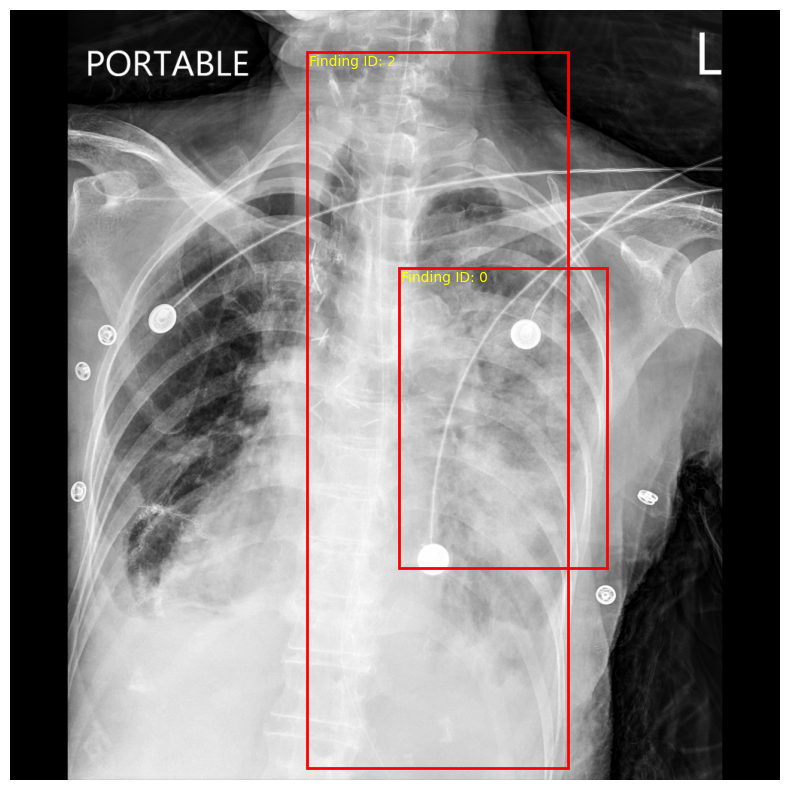

0. There is a new left perihilar infiltrate. * 
1. The right hemithorax is clear. 
2. Nasogastric tube overlies the stomach. * 


In [24]:
show_image_with_bbox(frontal, findings, path_lateral=None)

## 翻译: [['左侧肺门周围有新的浸润影。', [[0.505, 0.335, 0.775, 0.725]]], ['右侧胸腔清晰。', None], ['鼻胃管覆盖在胃上。', [[0.385, 0.055, 0.725, 0.985]]]]

## 5. Clean up resources - delete the online endpoint
Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint.

In [ ]:
ml_client.online_endpoints.begin_delete(name=endpoint_name).wait()